# All Variables Modelling

All variables are used to predict the Absorbance. 3 different models are used:
* linear regression
* random forest
* neural network

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error, r2_score

# Define paths

In [2]:
data_folder = os.path.join('..', 'data')

raw_data_folder = os.path.join(data_folder, 'raw_data')

# Load dataset

In [3]:
full_df = pd.read_excel(os.path.join(raw_data_folder, 'raw_full_dataset.xlsx'))

In [4]:
full_df

,DateTime,nitrate,pH,turbidity,Ammonium,dissolvedoxygen,watertemperature,Conductivity,redoxpotential,ABS254,cumulated_rainfall_24h,flowriver,environmental_temperature
0,2012-08-29,5.54,8.31,3.42,0.01,4.71,28.10,1144.98,220.47,9.07,0.0,100.82,27.02
1,2012-08-30,5.56,8.29,3.10,0.02,4.75,27.57,1205.67,225.81,15.13,0.4,97.40,22.49
2,2012-08-31,5.51,8.31,3.60,0.04,5.08,26.37,1237.20,229.83,15.95,0.0,95.59,21.03
3,2012-09-01,5.49,8.40,4.00,0.06,5.68,25.04,1254.15,231.82,NaN,0.0,94.97,17.81
4,2012-09-02,5.39,8.43,3.97,0.15,5.98,24.75,1244.10,234.80,15.10,0.0,95.48,19.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,2023-09-26,7.56,8.30,3.96,0.03,5.46,25.95,1628.49,227.69,3.97,0.0,83.50,20.50
4046,2023-09-27,7.28,8.29,4.16,0.02,5.33,26.37,1610.67,227.02,3.81,0.0,81.17,21.76
4047,2023-09-28,7.34,8.27,3.80,0.02,5.23,26.60,1602.33,228.25,3.76,0.0,81.42,22.17
4048,2023-09-29,7.64,8.25,3.89,0.03,5.17,26.73,1613.81,230.54,4.18,0.0,80.71,22.03


In [5]:
full_df.rename(
    columns={
        "flowriver": "Flow River",
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "environmental_temperature": "Air Temperature",
        'nitrate': 'Nitrate',
        'dissolvedoxygen': 'Dissolved Oxygen',
        'turbidity': 'Turbidity',
        'watertemperature': 'Water Temperature',
        'redoxpotential': 'Redox Potential',
        'ABS254': 'Absorbance 254nm',
    },
    inplace=True,
)

In [6]:
full_df.isna().sum()

DateTime                      0
Nitrate                     176
pH                           99
Turbidity                   218
Ammonium                    413
Dissolved Oxygen            325
Water Temperature            86
Conductivity                141
Redox Potential             273
Absorbance 254nm            551
Daily Cumulated Rainfall     10
Flow River                   46
Air Temperature               1
dtype: int64

In [7]:
full_df = full_df.dropna()

# Multicollinearity Test

In [8]:
X = full_df[full_df.columns.difference(['DateTime'])]


vif_test = pd.DataFrame()
vif_test['variable'] = X.columns
vif_test['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [9]:
vif_test

,variable,VIF
0,Absorbance 254nm,6.540941
1,Air Temperature,47.176356
2,Ammonium,3.173699
3,Conductivity,25.978670
4,Daily Cumulated Rainfall,1.069393
5,Dissolved Oxygen,48.783197
6,Flow River,7.219115
7,Nitrate,40.705111
8,Redox Potential,135.308202
9,Turbidity,3.208829


In [10]:
full_df['Year'] = full_df['DateTime'].dt.year
full_df['Month'] = full_df['DateTime'].dt.month
full_df['Season'] = full_df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Autumn')

# convert Season to integer
full_df['Season'] = full_df['Season'].apply(lambda x: 1 if x == 'Winter' else 2 if x == 'Spring' else 3 if x == 'Summer' else 4)

full_df['Timestamp'] = full_df['DateTime'].apply(lambda x: x.timestamp())

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89892/2418035427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Year'] = full_df['DateTime'].dt.year
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89892/2418035427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Month'] = full_df['DateTime'].dt.month
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89892/2418035427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [11]:
X = full_df[full_df.columns.difference(['DateTime'])]


vif_test = pd.DataFrame()
vif_test['variable'] = X.columns
vif_test['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [12]:
vif_test

,variable,VIF
0,Absorbance 254nm,2.848004
1,Air Temperature,9.194284
2,Ammonium,1.120169
3,Conductivity,2.567642
4,Daily Cumulated Rainfall,1.035261
5,Dissolved Oxygen,2.397270
6,Flow River,4.035563
7,Month,2.229043
8,Nitrate,1.914706
9,Redox Potential,1.271387


# Linear Regression

## All Features + Year

In [93]:
setting = 'All Features + Year'

### Split Data

In [94]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [95]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [96]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

### Train Model

In [97]:
model = sm.OLS(y_train_fit, sm.add_constant(X_train_fit)).fit()

In [98]:
results = model.summary2()

### Results

In [99]:
print(results)

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.599     
Dependent Variable:     Absorbance 254nm     AIC:                    12603.3425
Date:                   2024-03-12 16:15     BIC:                    12677.1607
No. Observations:       2161                 Log-Likelihood:         -6288.7   
Df Model:               12                   F-statistic:            269.9     
Df Residuals:           2148                 Prob (F-statistic):     0.00      
R-squared:              0.601                Scale:                  19.852    
-------------------------------------------------------------------------------
                           Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------------------
const                    2186.3038  81.5718  26.8022 0.0000 2026.3360 2346.2717
Air Temperature            -0.0177   0.0376  -0.4712 0.6376   -0

### Predictions

In [100]:
# predict the model
predictions = model.get_prediction(sm.add_constant(X_test_fit)).summary_frame(alpha=0.05)

In [101]:
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
3412,16.079149,0.584365,14.933169,17.225130,7.266657,24.891642
3413,13.741925,0.555608,12.652339,14.831510,4.936588,22.547261
3414,13.957956,0.501105,12.975254,14.940659,5.165206,22.750707
3415,13.175265,0.465141,12.263091,14.087440,4.390118,21.960413
3416,12.351150,0.436396,11.495347,13.206952,3.571676,21.130623
...,...,...,...,...,...,...
4045,4.699968,0.513463,3.693032,5.706904,-4.095524,13.495460
4046,4.554487,0.514241,3.546024,5.562950,-4.241180,13.350154
4047,4.386036,0.508175,3.389469,5.382603,-4.408275,13.180347
4048,4.421438,0.501111,3.438725,5.404151,-4.371314,13.214189


### Plots

In [102]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions['mean']))
r2 = r2_score(y_test_fit, predictions['mean'])

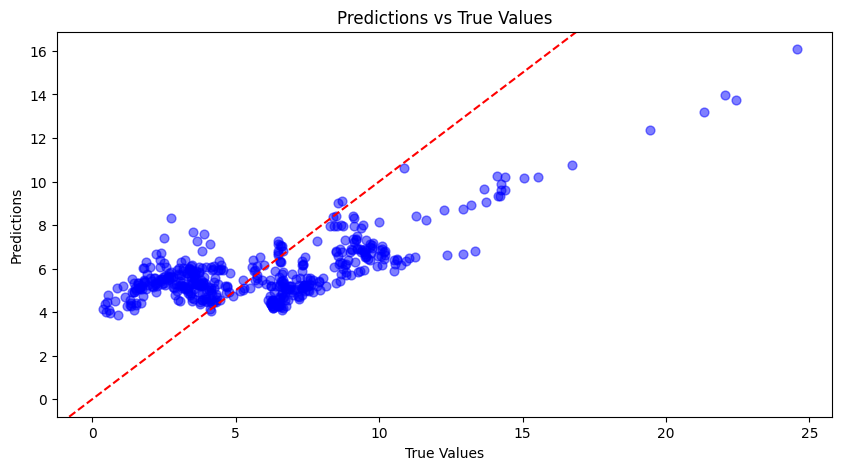

In [103]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions['mean'], c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

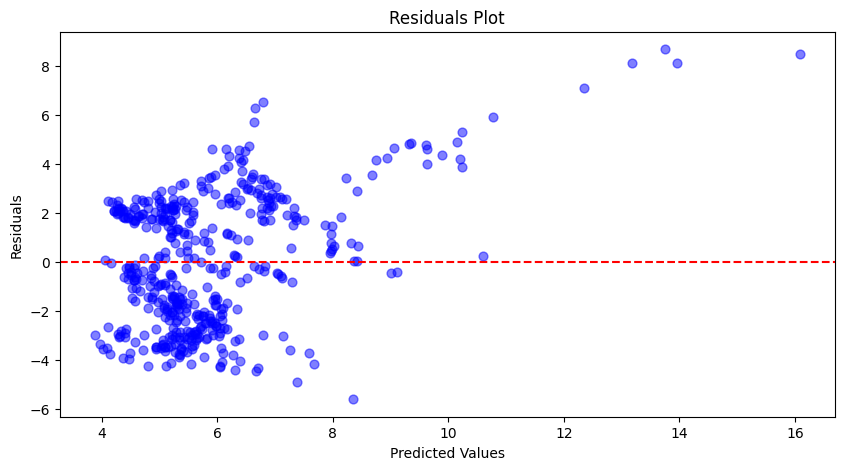

In [104]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - predictions['mean']
plt.figure(figsize=(10, 5))
plt.scatter(predictions['mean'], residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

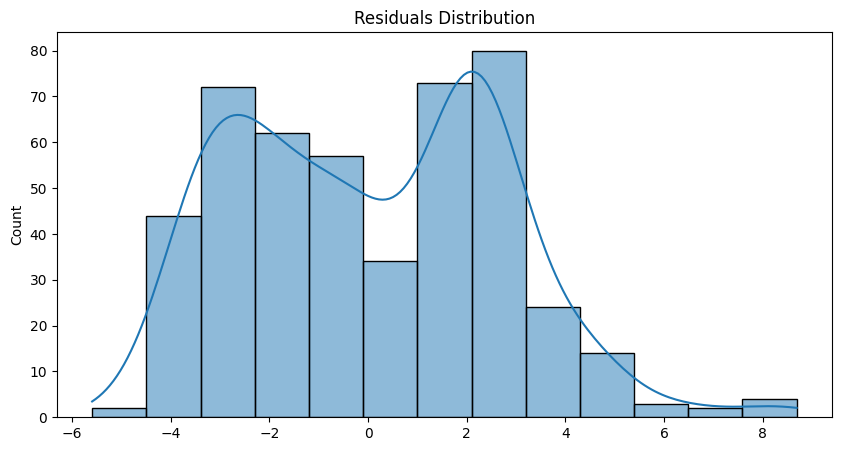

In [105]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

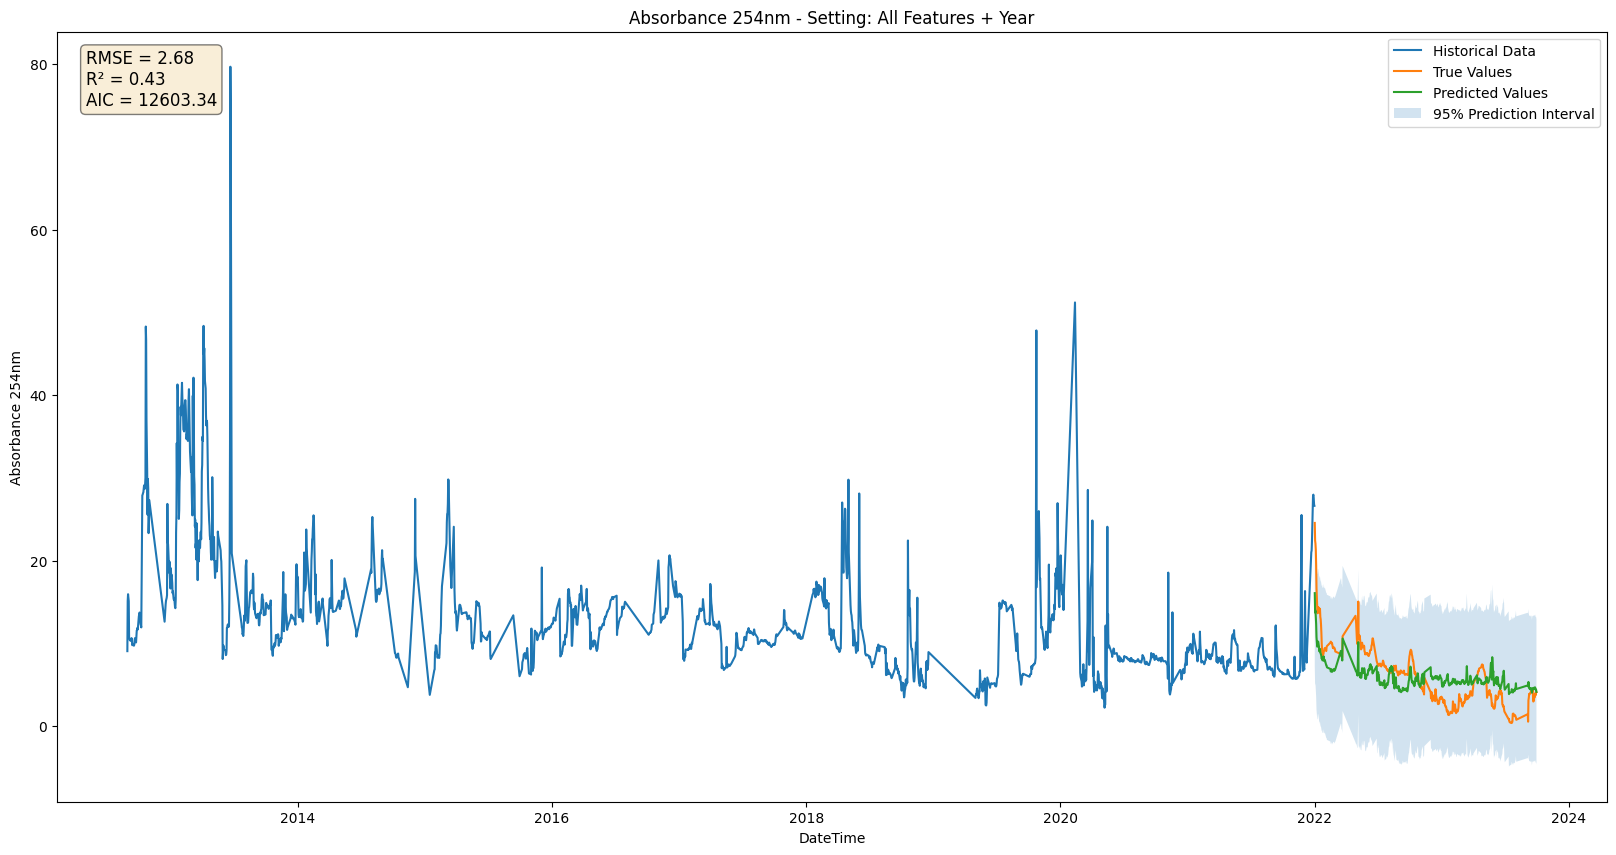

In [106]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=predictions['mean'], label='Predicted Values')
plt.fill_between(y_test['DateTime'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
    f'AIC = {model.aic:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

## Remove Features with p-value > 0.05

They are:

* Air Temperature
* Conductivity
* Daily Cumulated Rainfall
* Dissolved Oxygen
* Nitrate
* Water Temperature
* pH

In [121]:
setting = 'Ammonium + Flow River + Redox Potential + Turbidity + Year'

### Split Data

In [107]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp', 'Air Temperature', 'Daily Cumulated Rainfall', 'Nitrate', 'Dissolved Oxygen', 'Water Temperature', 'pH', 'Conductivity'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [108]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [110]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

### Train Model

In [111]:
model = sm.OLS(y_train_fit, sm.add_constant(X_train_fit)).fit()

In [112]:
results = model.summary2()

### Results

In [113]:
print(results)

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.595     
Dependent Variable:  Absorbance 254nm  AIC:                 12619.1607
Date:                2024-03-12 16:29  BIC:                 12653.2307
No. Observations:    2161              Log-Likelihood:      -6303.6   
Df Model:            5                 F-statistic:         635.0     
Df Residuals:        2155              Prob (F-statistic):  0.00      
R-squared:           0.596             Scale:               20.062    
----------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
----------------------------------------------------------------------
const           2222.5016  73.6915  30.1595 0.0000 2077.9877 2367.0156
Ammonium          15.8245   2.9345   5.3926 0.0000   10.0698   21.5792
Flow River         0.0034   0.0004   8.2855 0.0000    0.0026    0.0042
Redox Potential   -0.0358 

### Predictions

In [114]:
# predict the model
predictions = model.get_prediction(sm.add_constant(X_test_fit)).summary_frame(alpha=0.05)

In [115]:
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
3412,14.547489,0.384115,13.794214,15.300764,5.731412,23.363566
3413,12.252610,0.338098,11.589579,12.915642,3.443785,21.061436
3414,12.531600,0.315612,11.912665,13.150535,3.725984,21.337216
3415,11.885313,0.286655,11.323165,12.447462,3.083507,20.687120
3416,11.063857,0.267439,10.539391,11.588323,2.264376,19.863337
...,...,...,...,...,...,...
4045,5.130392,0.330665,4.481937,5.778848,-3.677348,13.938133
4046,5.026768,0.331550,4.376577,5.676959,-3.781100,13.834636
4047,4.914225,0.328095,4.270808,5.557641,-3.893146,13.721596
4048,5.005406,0.321938,4.374064,5.636749,-3.801090,13.811903


### Plots

In [116]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions['mean']))
r2 = r2_score(y_test_fit, predictions['mean'])

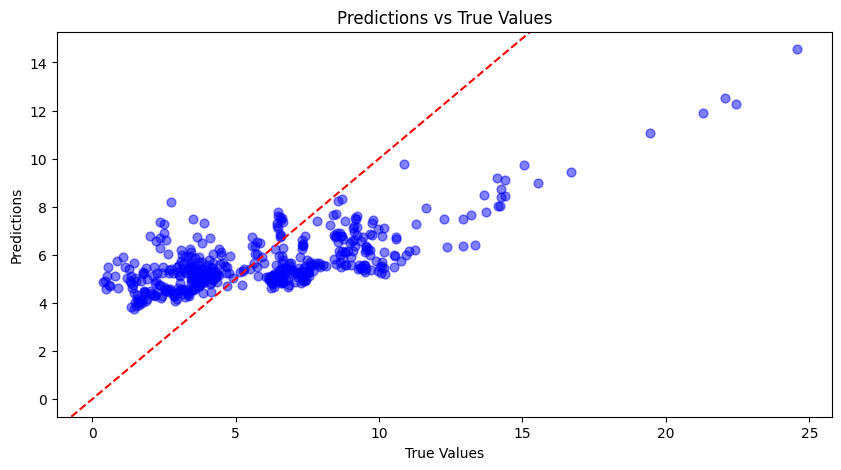

In [117]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions['mean'], c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

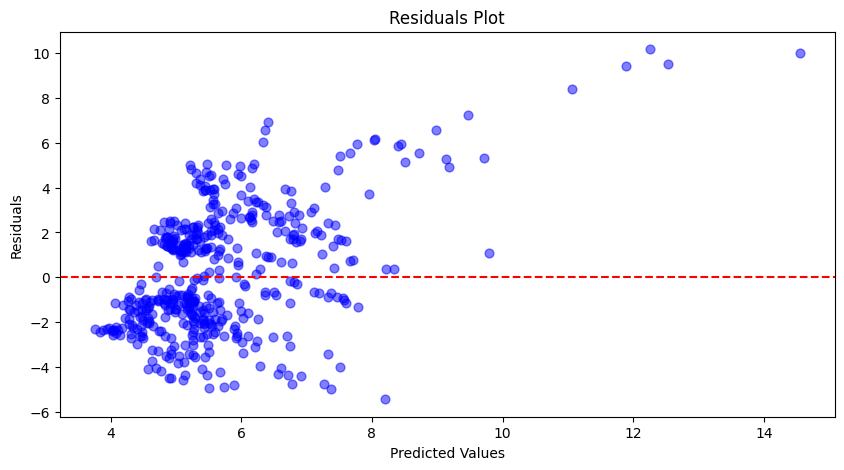

In [118]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - predictions['mean']
plt.figure(figsize=(10, 5))
plt.scatter(predictions['mean'], residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

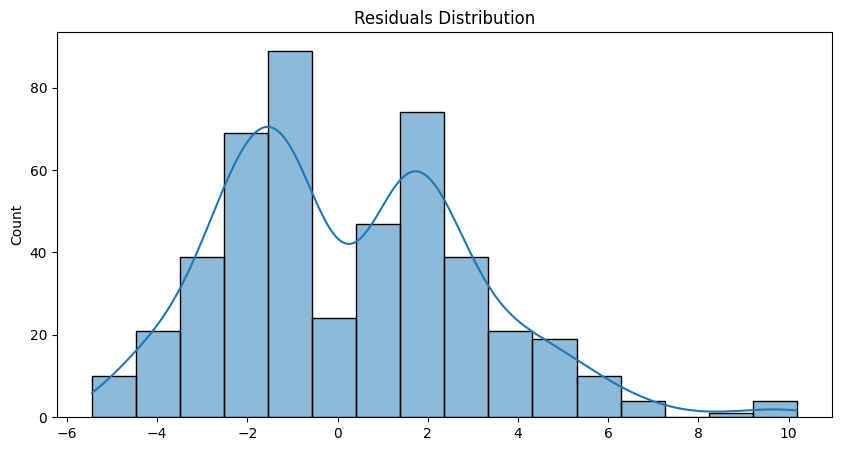

In [119]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

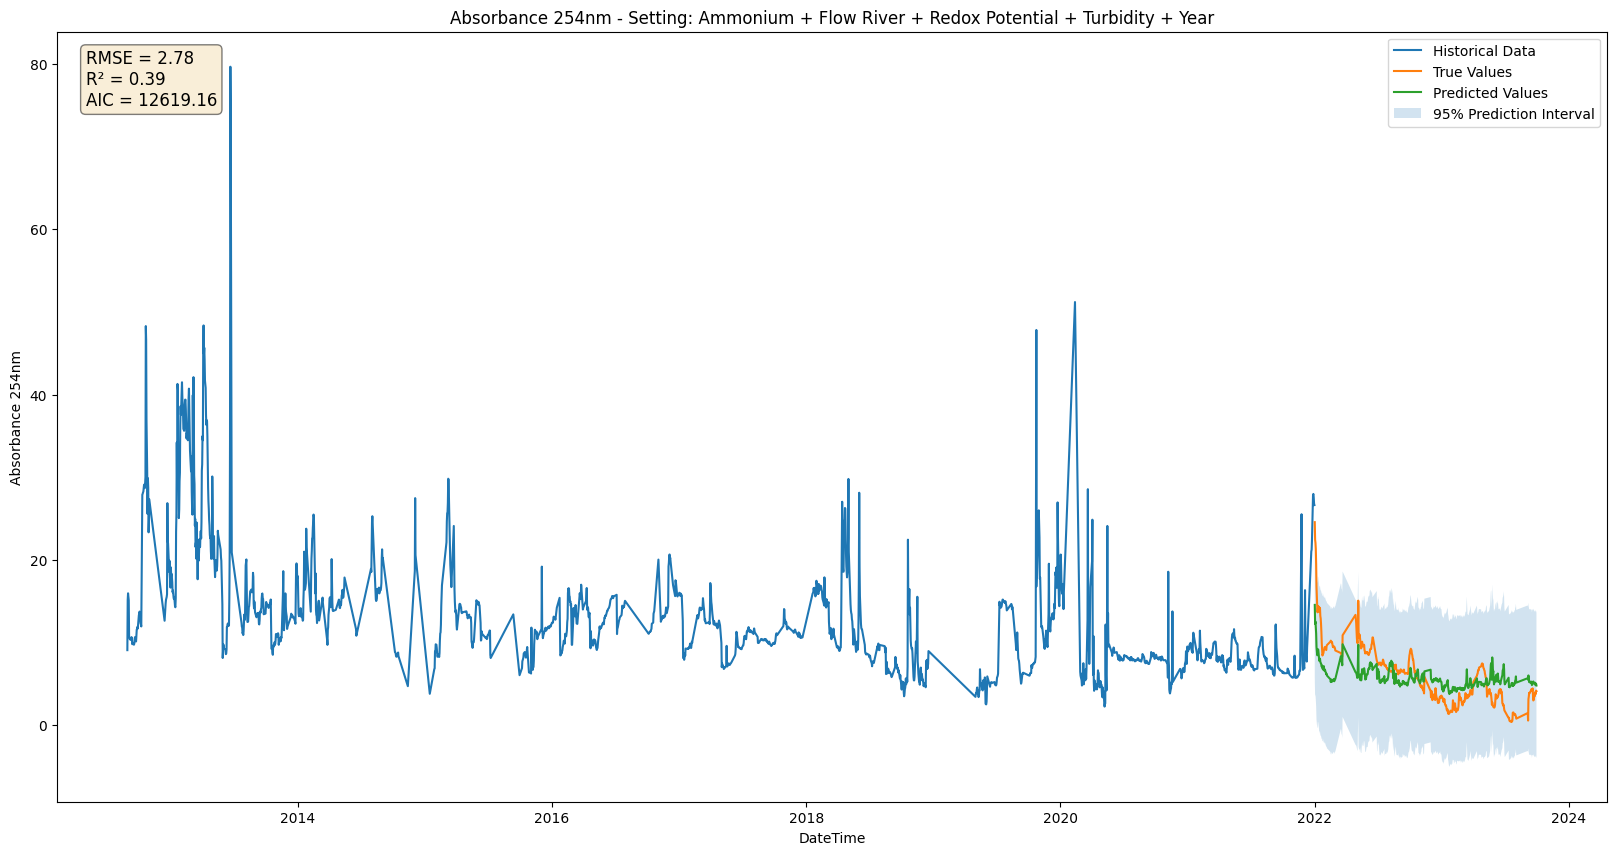

In [122]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=predictions['mean'], label='Predicted Values')
plt.fill_between(y_test['DateTime'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
    f'AIC = {model.aic:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

# Random Forest